In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sns
from sklearn import *
import xgboost as xg

In [6]:
train_data = pd.read_csv(r"train.csv")
test_data = pd.read_csv(r"test.csv")

In [7]:
%matplotlib inline
sns.set()


In [8]:
train_data.drop(columns=['homepage', 'imdb_id', 'original_title', 'poster_path'], inplace=True)
test_data.drop(columns=['homepage', 'imdb_id', 'original_title', 'poster_path'], inplace=True)

In [9]:
train_data.budget = train_data.budget.astype(float)
train_data.revenue = train_data.revenue.astype(float)
test_data.budget = test_data.budget.astype(float)

Text(0.5, 1.0, 'Missing Value count By Features')

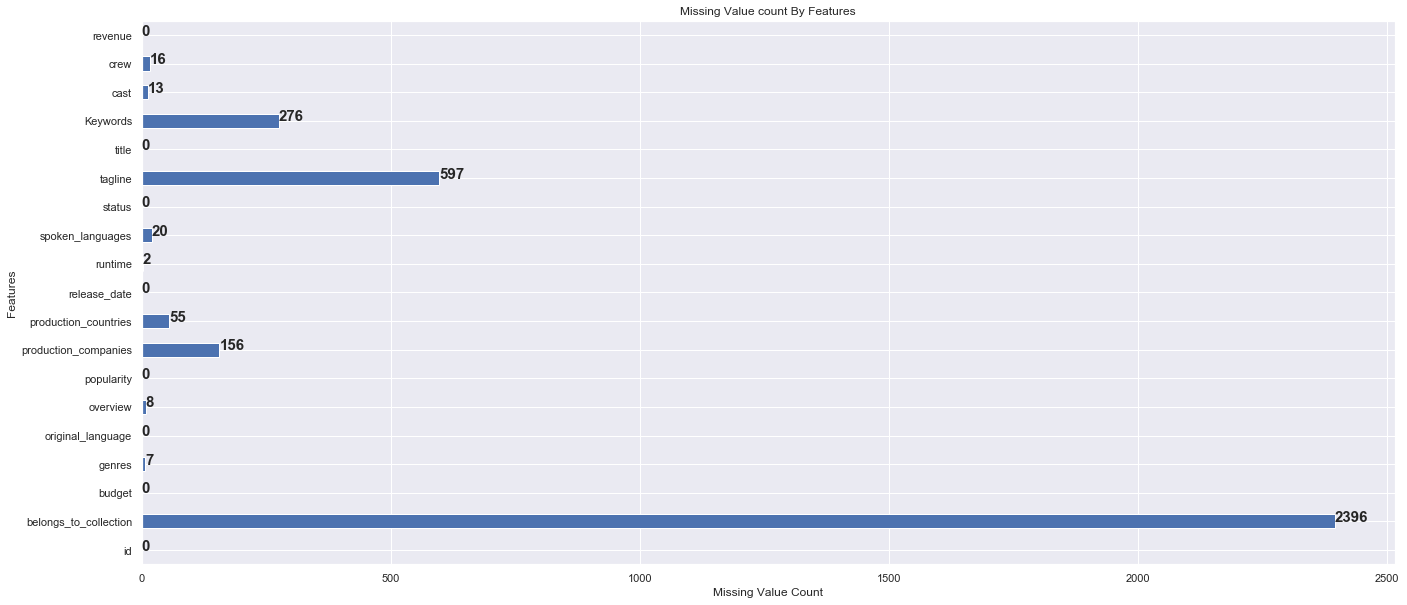

In [10]:
train_data.isna().sum().plot(kind="barh", figsize=(20,10))
for i, v in enumerate(train_data.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
plt.xlabel("Missing Value Count")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

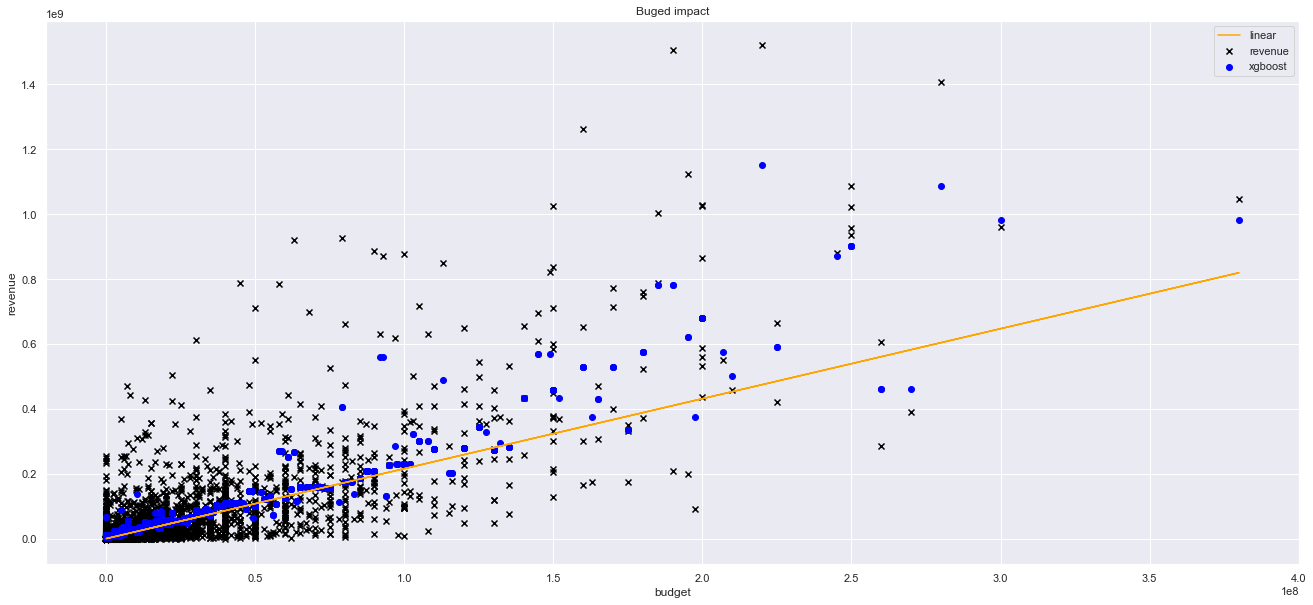

In [12]:
# We plot the scatter of the budget / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = train_data['budget'], y = train_data['revenue'], marker = 'x', color = 'black')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train_data['budget']).reshape(-1,1), y = train_data['revenue'])
rev_pred = model.predict(np.array(train_data['budget']).reshape(-1,1))

# We plot the fit 
plt.plot(train_data['budget'], rev_pred, color = 'orange', label = 'linear')


# We fit an xgboost model 
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(np.array(train_data['budget']).reshape(-1,1), np.array(train_data['revenue']))
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(np.array(train_data['budget']).reshape(-1,1))
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(train_data['budget'], rev_pred, color = 'blue', label = 'xgboost')


plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Buged impact')
plt.legend()
plt.show()

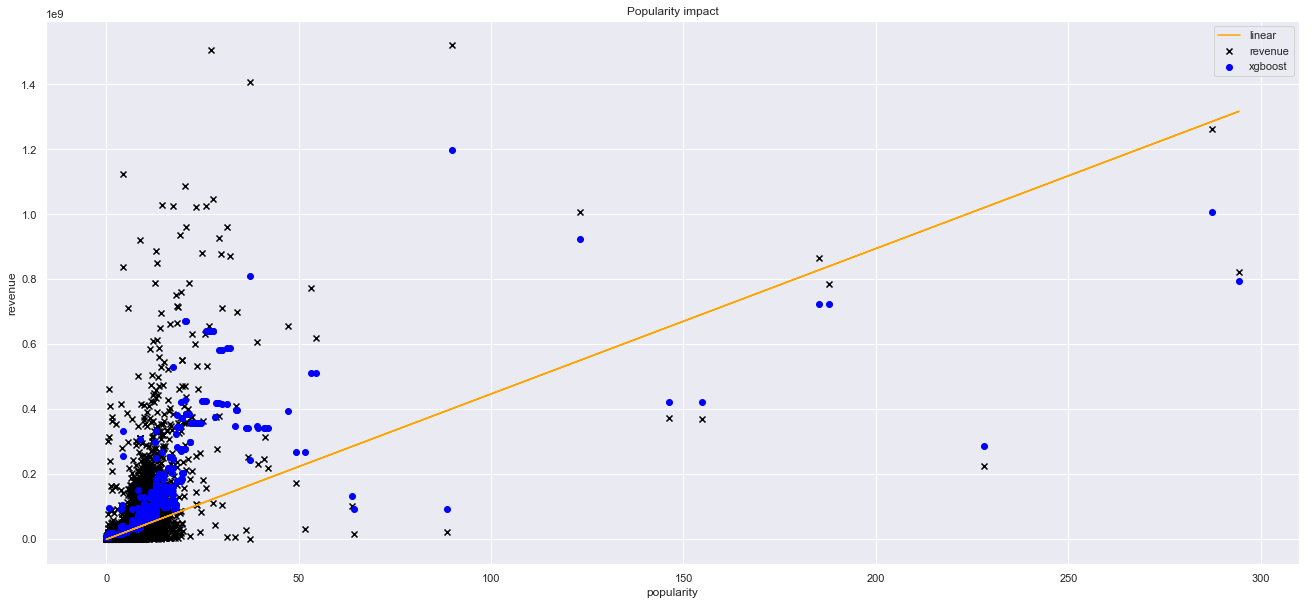

In [13]:
# We plot the scatter of the popularity / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = train_data['popularity'], y = train_data['revenue'], marker = 'x', color = 'black')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train_data['popularity']).reshape(-1,1), y = train_data['revenue'])
rev_pred = model.predict(np.array(train_data['popularity']).reshape(-1,1))

# We plot the fit 
plt.plot(train_data['popularity'], rev_pred, color = 'orange', label = 'linear')


# We fit an xgboost model 
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(np.array(train_data['popularity']).reshape(-1,1), np.array(train_data['revenue']))
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(np.array(train_data['popularity']).reshape(-1,1))
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(train_data['popularity'], rev_pred, color = 'blue', label = 'xgboost')


plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title('Popularity impact')
plt.legend()
plt.show()

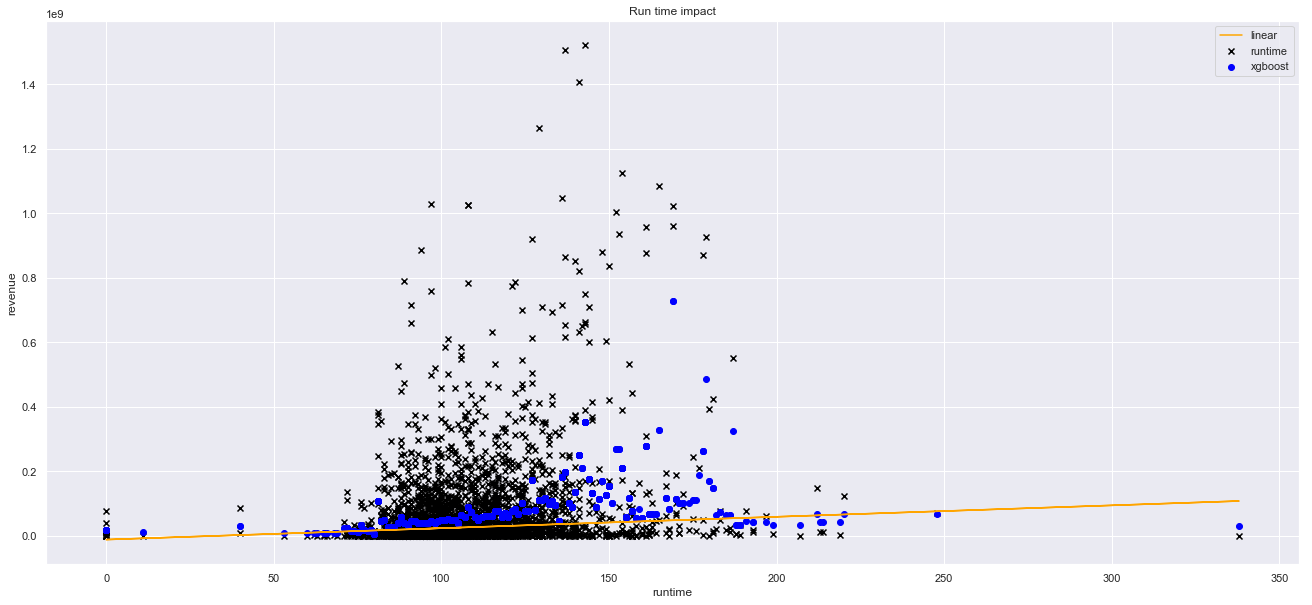

In [14]:
idxs = np.where(train_data['runtime'].isna() == False)[0]
runtime = np.array(train_data['runtime'][idxs]).reshape(-1,1)
revenue = np.array(train_data['revenue'][idxs])

# We plot the scatter of the budget / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = runtime, y = revenue, marker = 'x', color = 'black', label = 'runtime')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = runtime, y = revenue)
rev_pred = model.predict(runtime)

# We plot the fit 
plt.plot(runtime, rev_pred, color = 'orange', label = 'linear')


# We fit an xgboost model 
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(runtime, revenue)
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(runtime)
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(runtime, rev_pred, color = 'blue', label = 'xgboost')


plt.xlabel('runtime')
plt.ylabel('revenue')
plt.title('Run time impact')
plt.legend()
plt.show()

Movies in saga: 3000/3000=100.0% 


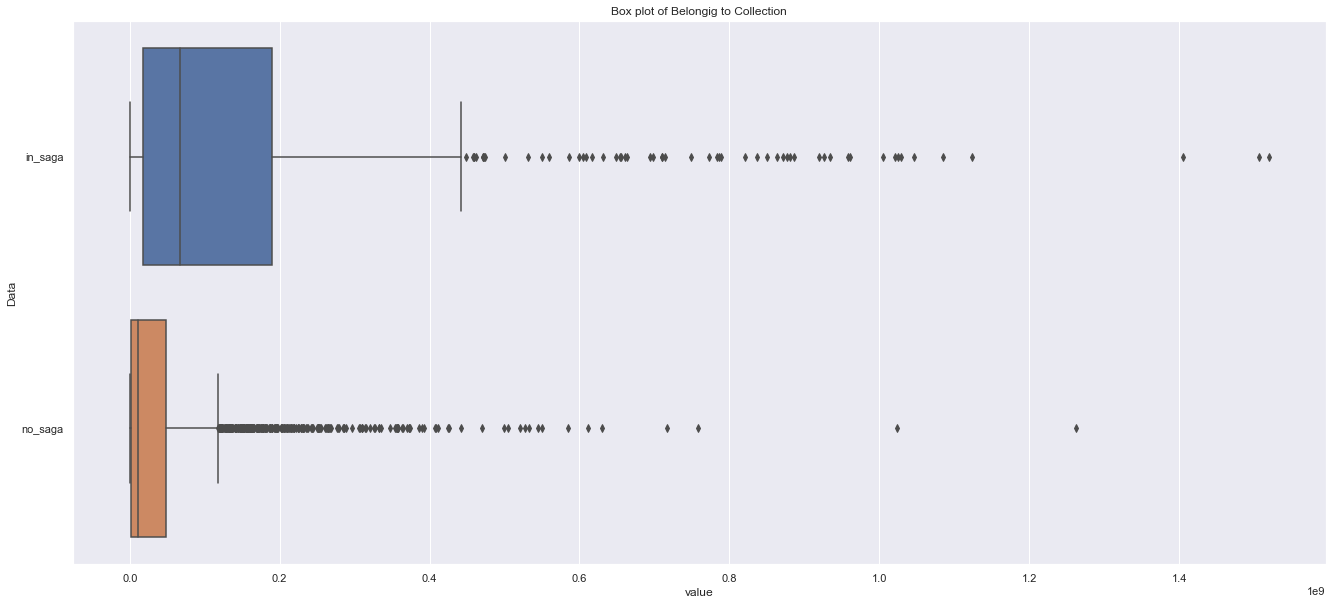

In [15]:
# "belongs_to_collection": Clean, EDA and create bool > True if belongs to a saga, False if not
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange','medians': 'DarkBlue', 'caps': 'Gray'}
plt.figure(figsize=(20,10))
belongs_df = train_data[['belongs_to_collection', 'revenue']]
belongs_df['belongs_to_collection_bool'] = True
belongs_df.belongs_to_collection_bool[train_data.belongs_to_collection.isnull()] = False
belongs_df['in_saga'] = np.nan
belongs_df.in_saga[belongs_df.belongs_to_collection_bool == True] = belongs_df.revenue[belongs_df.belongs_to_collection_bool == True] 
belongs_df['no_saga'] = np.nan
belongs_df.no_saga[belongs_df.belongs_to_collection_bool == False] = belongs_df.revenue[belongs_df.belongs_to_collection_bool == False] 
belongs_df.belongs_to_collection[~train_data.belongs_to_collection.isnull()] = train_data.belongs_to_collection[~train_data.belongs_to_collection.isnull()].str.split("'name': '").str[1].str.split("', 'poster").str[0]
belongs_df.drop(columns=['revenue', 'belongs_to_collection', 'belongs_to_collection_bool'], inplace=True)
print("Movies in saga: {}/{}={}% ".format(len(~belongs_df.in_saga.isnull()), len(belongs_df), 100.0*len(~belongs_df.in_saga.isnull())/len(belongs_df)))
# belongs_boxplot = belongs_df.boxplot(figsize=(15, 10), rot=90)
sns.boxplot(data=belongs_df, orient='h')
plt.xlabel('value')
plt.ylabel('Data')
plt.title('Box plot of Belongig to Collection')
plt.show()

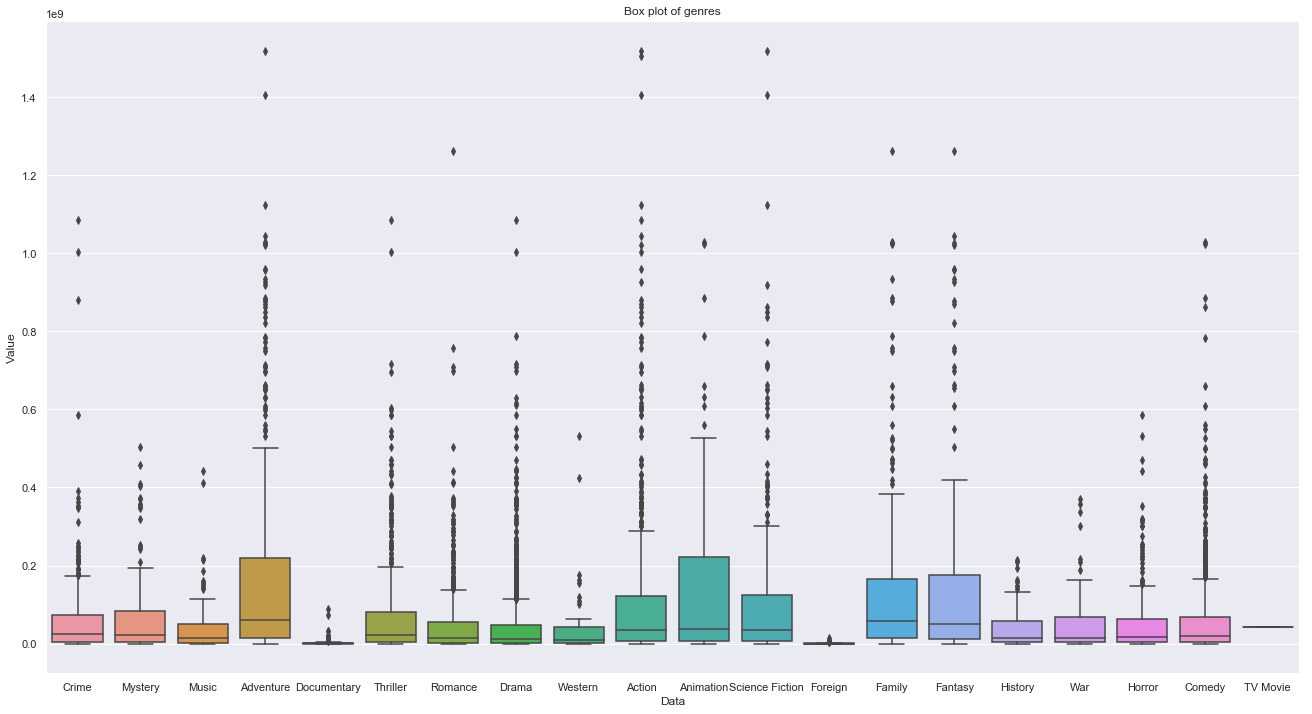

In [16]:
# "genres": Clean, EDA and create bools > True if belongs to a specific genre, False if not
genres_df = train_data[['genres', 'revenue']]
genres_df['genres_test'] = genres_df['genres']
# genres_df['number_genres'] = genres_df.genres.str.count("'id'").fillna(0.0).astype(int)
genres_df.genres_test = genres_df.genres_test.str.strip('[]')
genres_df.genres_test[genres_df.genres_test.isnull()] = ''
genres_list = pd.Series(list(set(", ".join(genres_df.genres_test.unique().tolist()).split('}, ')))).str.split("'name': '").str[1].str.split("'").str[0].tolist()
for i, genre in enumerate(genres_list):
    genres_df[genre] = np.nan
    genres_df[genre][genres_df.genres_test.str.contains(genre)] = genres_df.revenue[genres_df.genres_test.str.contains(genre)]
genres_df.drop(columns=['revenue', 'genres', 'genres_test'], inplace=True)
# genres_boxplot = genres_df.boxplot(figsize=(15, 10), rot=90)
plt.figure(figsize=(20,12))
sns.boxplot(data=genres_df)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Box plot of genres')
plt.show()

No handles with labels found to put in legend.


125


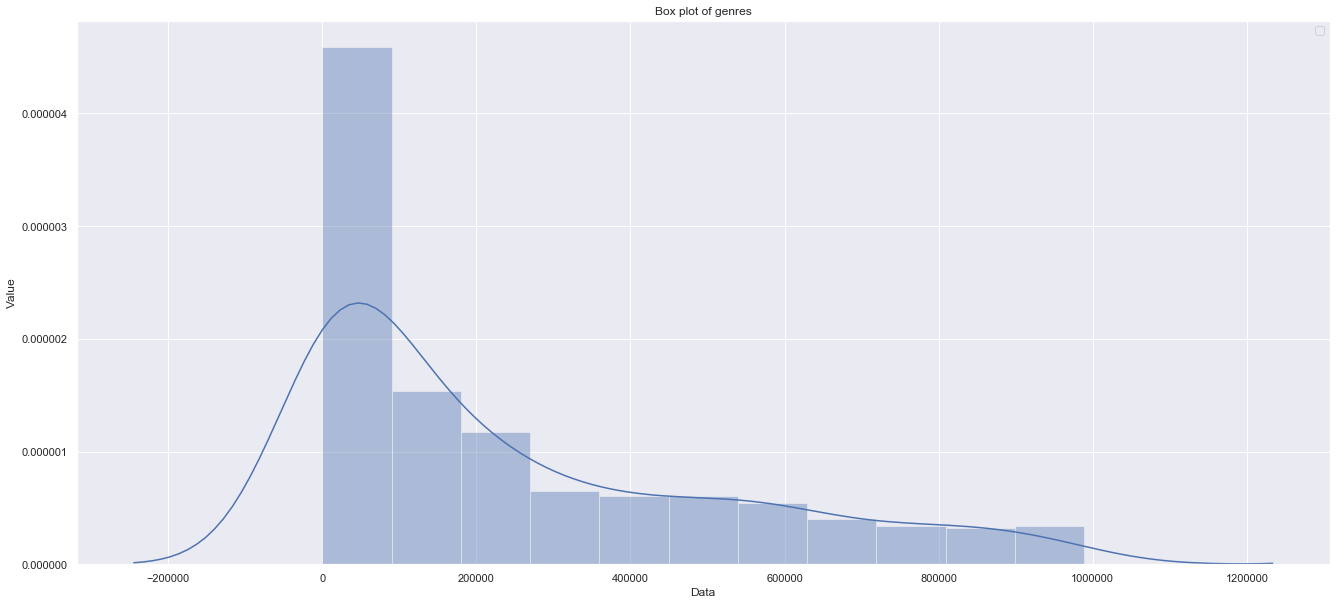

In [17]:
revenue_df = train_data[['title', 'revenue']].sort_values('revenue')
print(len(revenue_df[revenue_df.revenue<2e4]))
revenue_boxplot = revenue_df[['revenue']][revenue_df.revenue < 1e6]
plt.figure(figsize=(20,10))
sns.distplot(revenue_boxplot)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Box plot of genres')
plt.legend()
plt.show()

No handles with labels found to put in legend.


849


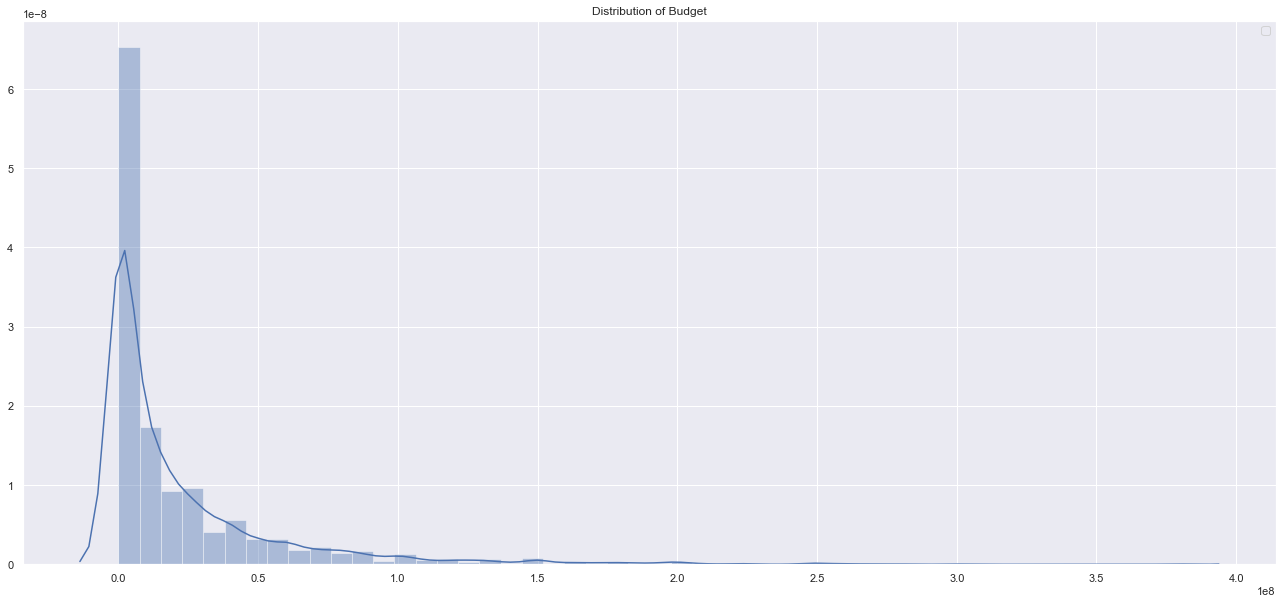

In [18]:
budget_df = train_data[['title', 'budget']].sort_values('budget')
print(len(budget_df[budget_df.budget<1e5]))
budget_boxplot = budget_df[['budget']][budget_df.budget < 1e9]
plt.figure(figsize=(20,10))
sns.distplot(budget_boxplot)
plt.title('Distribution of Budget')
plt.legend()
plt.show()

In [19]:
# "status": Study the two existing values
status_df = train_data[['status', 'revenue']]

status_df = status_df.groupby('status', as_index=False).agg({'revenue' : ['min', 'max', 'mean', 'count']})
print("Possible status: {} ".format(status_df.status.unique().tolist()))
status_df.head()

Possible status: ['Released', 'Rumored'] 


status revenue                                  
                min           max          mean count
0  Released     1.0  1.519558e+09  6.681029e+07  2996
1   Rumored    60.0  1.341809e+07  3.480199e+06     4

No handles with labels found to put in legend.


1416


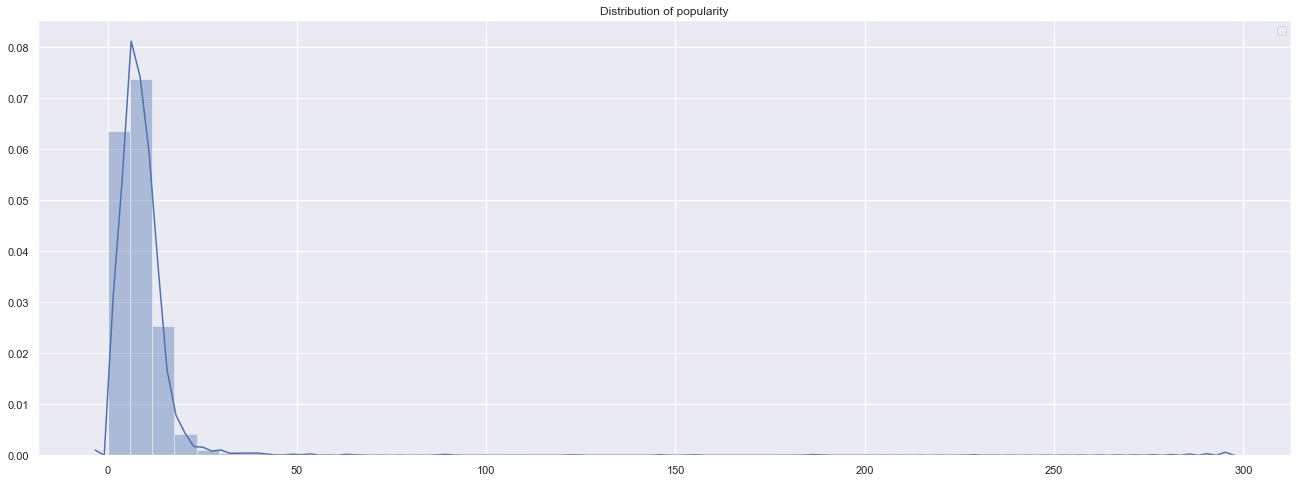

In [20]:
popularity_df = train_data[['title', 'popularity']].sort_values('popularity')
print(len(popularity_df[popularity_df.popularity<7]))
popularity_boxplot = popularity_df[['popularity']]
plt.figure(figsize=(20,8))
sns.distplot(popularity_boxplot)
plt.title('Distribution of popularity')
plt.legend()
plt.show()

In [21]:
title_df = train_data[['title', 'belongs_to_collection']].sort_values('title')
print("Non-null titles: {}, Non-null unique titles: {} ".format(len(title_df.title), len(title_df.title.unique())))
print("Duplicated movies: {} ".format(title_df.title[title_df.duplicated(keep='first')].tolist()))
print("Titles that belong to a collection {} ".format(len(title_df[~title_df.belongs_to_collection.isnull()])))
number_tuple = (' 0', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', ' 7', ' 8', ' 9')
title_df = title_df[(~title_df.belongs_to_collection.isnull()) & (title_df.title.str.endswith(number_tuple))]
print("Titles that belong to a collection and indicate the number of movie {} ".format(len(title_df)))

Non-null titles: 3000, Non-null unique titles: 2969 
Duplicated movies: ['Anna Karenina', 'Beauty and the Beast', 'Ben-Hur', 'Black Sheep', 'Casino Royale', 'Deadfall', 'Ghost', 'Hot Pursuit', 'Joshua', 'Lolita', 'Loose Cannons', 'Priest', 'Red Dawn', 'Sahara', 'Scarface', 'Stolen', 'Superbad', 'The Double', 'The Gift', 'The One and Only', 'The Other Woman', 'The Three Musketeers', 'The Women', 'Unknown'] 
Titles that belong to a collection 604 
Titles that belong to a collection and indicate the number of movie 57 
